# 네이버 검색어 트랜드

## #01. 작업준비

### 패키지 참조

In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import requests
import pandas as pd
import json
from datetime import datetime as dt
# from datetime import timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb
from helper import set_datetime_index, exp_timedata
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


# import pyupbit


In [2]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

## #02. 네이버 검색어 트랜드 openapi 연동

### 접속에 필요한 정보 설정

#### API URL

In [3]:
API_URL = 'https://openapi.naver.com/v1/datalab/search'



### 발급받은 인증키

In [4]:
client_id = 'VqTW9_KhmB5W3mCHYf_M' 
client_secret = 'eqDpF2HwLw'



### 접속 객체 생성

In [5]:
session = requests.Session()
session.headers.update({
    "X-Naver-Client-Id":client_id,
    "X-Naver-Client-Secret":client_secret
})

### 접속시도 

#### https get 방식인경우
: session.get(API_URL,params={'a':100,'b':200})

#### https post 방식인 경우
: session.post(API_URL,data={'a':100,'b':200})

#### https post 방식이면서 파라미터를 json으로 구성하는 경우 (body 데이터 전송)
: session.post(API_URL,data=json.dum({'a':100,'b':200}))






### 전달할 검색어 구성

In [11]:
data = {
    'startDate'  :'2021-07-01', ## 2016/01/01 부터 가능
    'endDate'  :'2023-07-31',
    'timeUnit' : 'date',       ## date, week, month
    'keywordGroups':[
        {
            "groupName":'Benz',  ## 검색 주제 
            'keywords' : ['e클래스','s클래스','c클래스','벤츠 cls'] ## 주제와 관련된 키워드들
        },
        {
            "groupName":'BMW',  ## 검색 주제 
            'keywords' : ['5시리즈','x5','x7','x3'] ## 주제와 관련된 키워드들
        },
        {
            "groupName":'AUDI',  ## 검색 주제 
            'keywords' : ['a6','e트론','a7','q5'] ## 주제와 관련된 키워드들
        }
    ]
}

### 데이터 요청하기 


In [12]:
r = session.post(API_URL,data = json.dumps(data))
## 접속에 실패한 경우
if r.status_code!=200:
    # 에러코드와 에러 메세지 출력
    msg="{%d Error} %s 에러가 발생함" % (r.status_code,r.reason)
    # 에러를 강제로 생성시킴
    raise Exception(msg)
r.encoding = "utf-8"
mydict = json.loads(r.text)
mydict

{'startDate': '2021-07-01',
 'endDate': '2023-07-31',
 'timeUnit': 'date',
 'results': [{'title': 'Benz',
   'keywords': ['e클래스', 's클래스', 'c클래스', '벤츠 cls'],
   'data': [{'period': '2021-07-01', 'ratio': 27.95718},
    {'period': '2021-07-02', 'ratio': 28.37644},
    {'period': '2021-07-03', 'ratio': 28.90276},
    {'period': '2021-07-04', 'ratio': 28.5727},
    {'period': '2021-07-05', 'ratio': 32.89027},
    {'period': '2021-07-06', 'ratio': 29.07225},
    {'period': '2021-07-07', 'ratio': 28.07314},
    {'period': '2021-07-08', 'ratio': 27.47546},
    {'period': '2021-07-09', 'ratio': 26.57448},
    {'period': '2021-07-10', 'ratio': 29.73238},
    {'period': '2021-07-11', 'ratio': 30.21409},
    {'period': '2021-07-12', 'ratio': 27.9661},
    {'period': '2021-07-13', 'ratio': 29.81266},
    {'period': '2021-07-14', 'ratio': 30.45495},
    {'period': '2021-07-15', 'ratio': 32.31935},
    {'period': '2021-07-16', 'ratio': 35.9322},
    {'period': '2021-07-17', 'ratio': 36.06601},
    {

### 응답 결과 구조



In [13]:
print("검색 결과 수 : ", len(mydict['results']))

검색 결과 수 :  3


In [14]:
title = mydict['results'][0]['title']
print(title)
data = mydict['results'][0]['data']
df1 = pd.DataFrame(data)
df1.rename(columns={'ratio':title},inplace=True)
df1.head()

Benz


,period,Benz
0,2021-07-01,27.95718
1,2021-07-02,28.37644
2,2021-07-03,28.90276
3,2021-07-04,28.57270
4,2021-07-05,32.89027


In [15]:
title2 = mydict['results'][1]['title']
print(title2)
data2 = mydict['results'][1]['data']

df2 = pd.DataFrame(data2)
df2.rename(columns={'ratio':title2},inplace=True)
df2.head()

BMW


,period,BMW
0,2021-07-01,44.38001
1,2021-07-02,45.88760
2,2021-07-03,47.01159
3,2021-07-04,46.68153
4,2021-07-05,47.79661


In [16]:
title3 = mydict['results'][2]['title']
print(title3)
data3 = mydict['results'][2]['data']
df3 = pd.DataFrame(data3)
df3.rename(columns={'ratio':title3},inplace=True)
df3.head()

AUDI


,period,AUDI
0,2021-07-01,25.38804
1,2021-07-02,27.56467
2,2021-07-03,26.39607
3,2021-07-04,27.27921
4,2021-07-05,28.90276


In [19]:
tmp = pd.merge(df1,df2,how='outer')
df= pd.merge(tmp,df3,how='outer')
df.head()

,period,Benz,BMW,AUDI
0,2021-07-01,27.95718,44.38001,25.38804
1,2021-07-02,28.37644,45.88760,27.56467
2,2021-07-03,28.90276,47.01159,26.39607
3,2021-07-04,28.57270,46.68153,27.27921
4,2021-07-05,32.89027,47.79661,28.90276


## #03. 연동 결과에 대한 시계열 분석
### 데이터 타입 확인

In [20]:
df.dtypes

period     object
Benz      float64
BMW       float64
AUDI      float64
dtype: object

### 날짜 칼럼에 대한 형변환 및 인덱스 지정

In [23]:
df.head()

,period,Benz,BMW,AUDI
0,2021-07-01,27.95718,44.38001,25.38804
1,2021-07-02,28.37644,45.88760,27.56467
2,2021-07-03,28.90276,47.01159,26.39607
3,2021-07-04,28.57270,46.68153,27.27921
4,2021-07-05,32.89027,47.79661,28.90276


In [32]:
df['period'] = pd.to_datetime(df['period'])
df2 = set_datetime_index(df,'period')
df2

,Benz,BMW,AUDI
2021-07-01,27.95718,44.38001,25.38804
2021-07-02,28.37644,45.88760,27.56467
2021-07-03,28.90276,47.01159,26.39607
2021-07-04,28.57270,46.68153,27.27921
2021-07-05,32.89027,47.79661,28.90276
...,...,...,...
2023-07-27,33.31846,61.78412,17.88581
2023-07-28,36.15521,66.67261,19.30419
2023-07-29,36.05709,67.38626,17.71632
2023-07-30,36.82426,67.67172,16.85994


In [33]:
df3 = df2.reset_index()
df3.head()

,index,Benz,BMW,AUDI
0,2021-07-01,27.95718,44.38001,25.38804
1,2021-07-02,28.37644,45.88760,27.56467
2,2021-07-03,28.90276,47.01159,26.39607
3,2021-07-04,28.57270,46.68153,27.27921
4,2021-07-05,32.89027,47.79661,28.90276


In [38]:
df4 = pd.melt(df3,id_vars=['index'],value_vars=['Benz','BMW','AUDI'],var_name='키워드',value_name='검색량')
df4.set_index('index',inplace=True)
df4.head()

,키워드,검색량
index,,
2021-07-01,Benz,27.95718
2021-07-02,Benz,28.37644
2021-07-03,Benz,28.90276
2021-07-04,Benz,28.57270
2021-07-05,Benz,32.89027


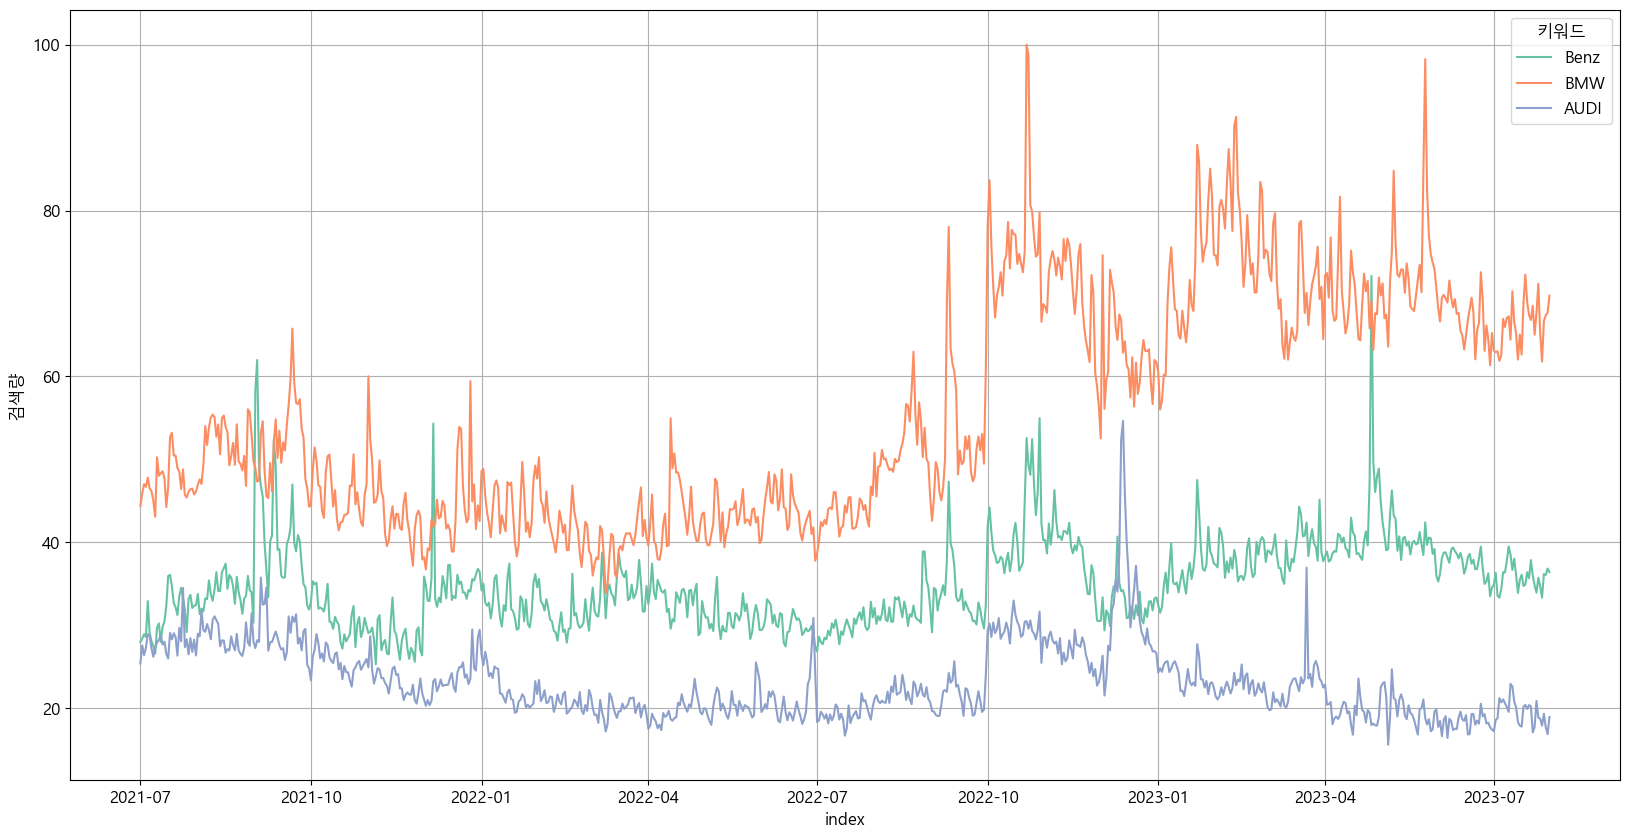

In [39]:
plt.figure(figsize=(20, 10))
sb.lineplot(data=df4, y='검색량', x=df4.index, hue='키워드', palette='Set2')
plt.grid()
plt.show()
plt.close()

In [41]:
df2.head()

,Benz,BMW,AUDI
2021-07-01,27.95718,44.38001,25.38804
2021-07-02,28.37644,45.88760,27.56467
2021-07-03,28.90276,47.01159,26.39607
2021-07-04,28.57270,46.68153,27.27921
2021-07-05,32.89027,47.79661,28.90276


Benz
결측치 수 :  0


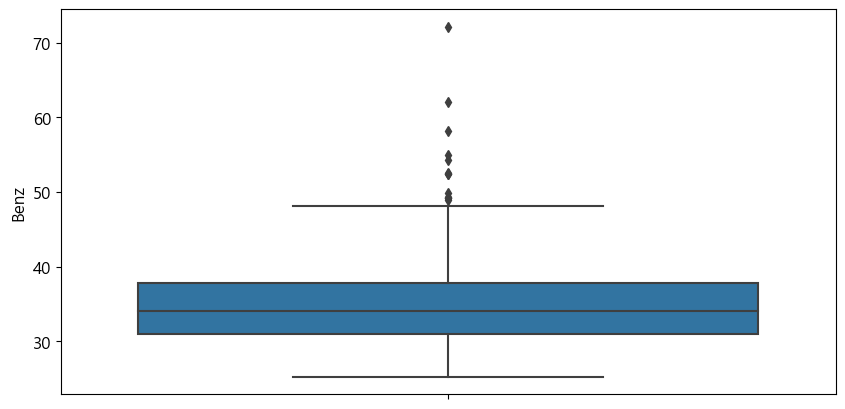

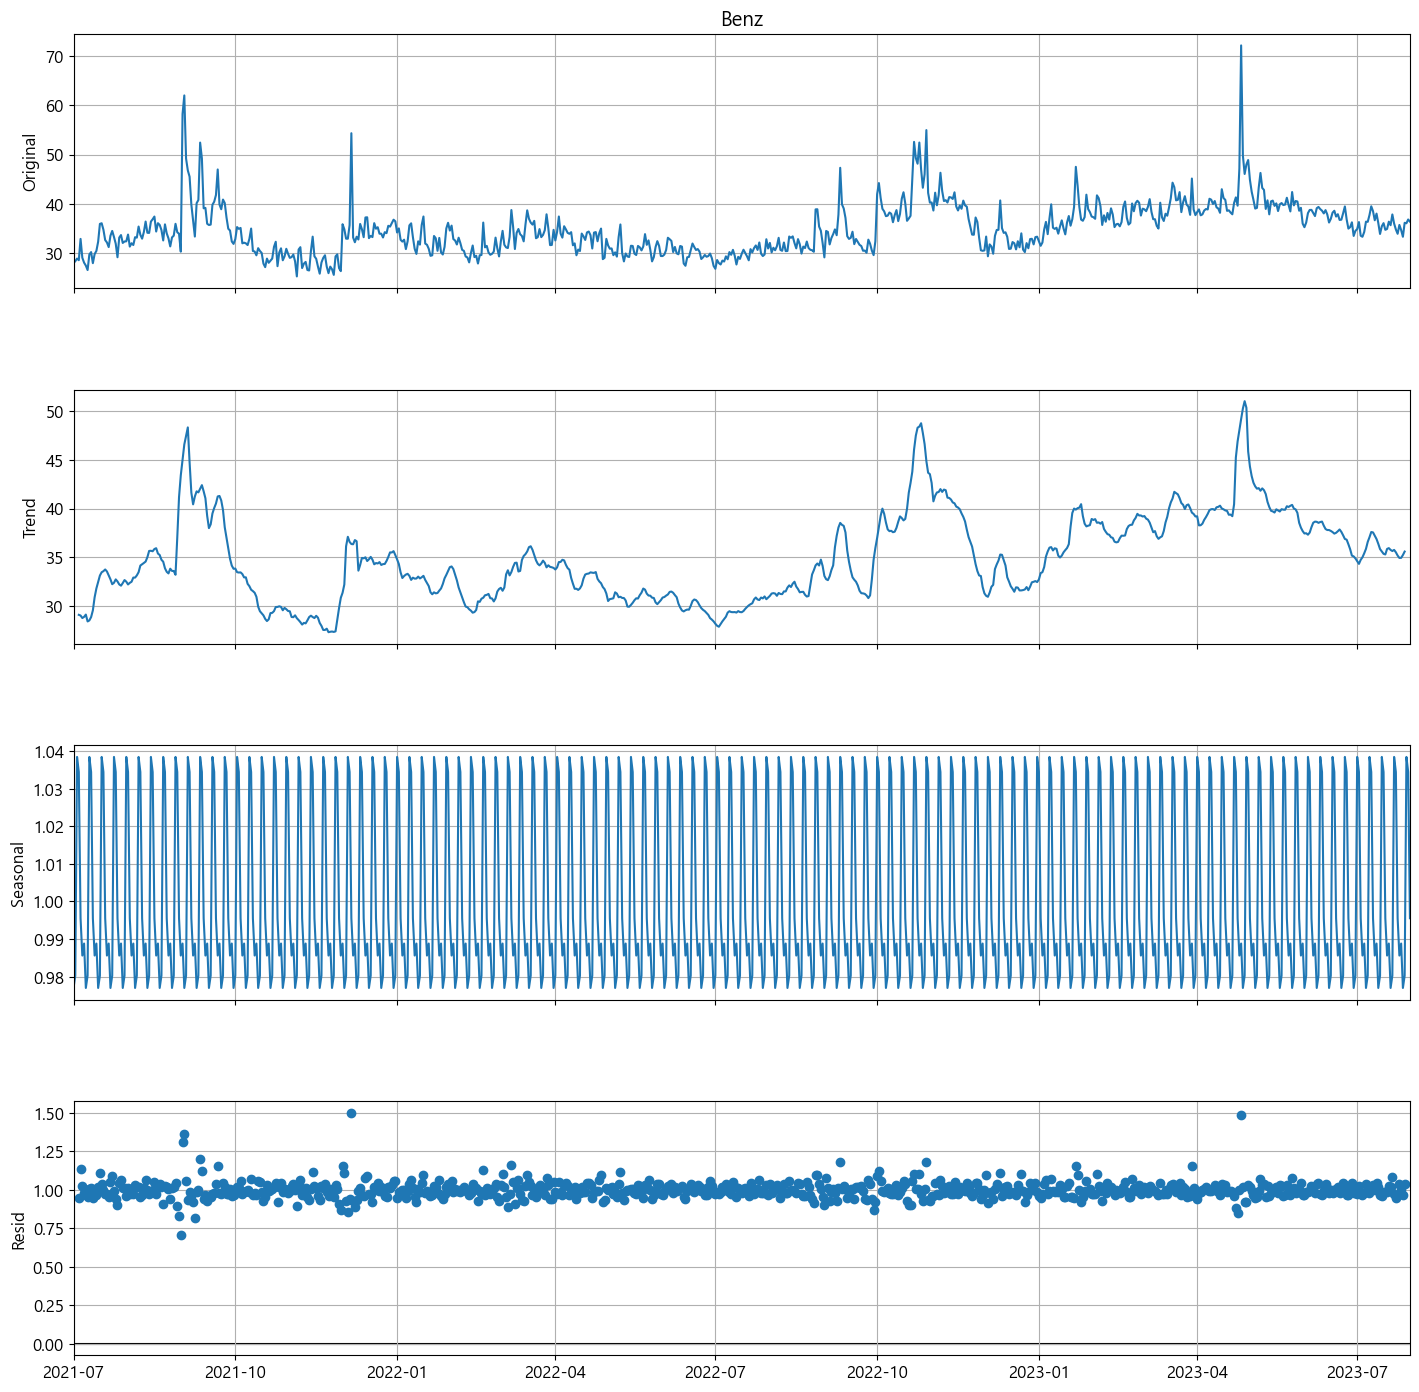

=========== 원본 데이터 ===========
+------------------------------------+-----------+
| ADF                                |           |
|------------------------------------+-----------|
| 검정통계량 (ADF Statistic)         |  -3.03839 |
| p-value                            | 0.0314614 |
| 최적 차수                          |        12 |
| 관측치 개수                        |       748 |
| 기각값 1%                          |  -3.43912 |
| 기각값 5%                          |  -2.86541 |
| 기각값 10%                         |  -2.56883 |
| 데이터 정상성 여부(0=Flase,1=True) |         1 |
+------------------------------------+-----------+


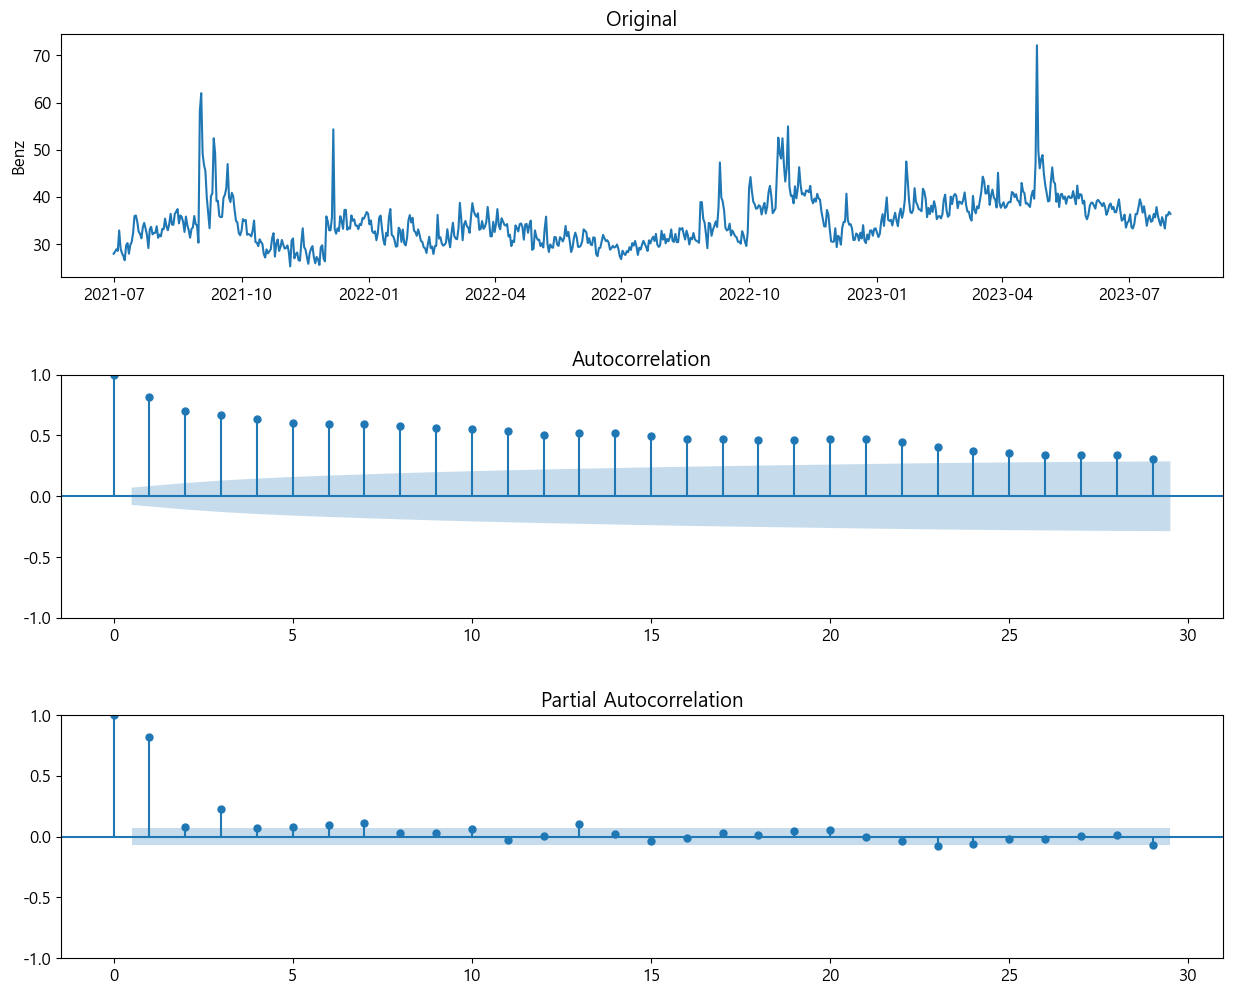

BMW
결측치 수 :  0


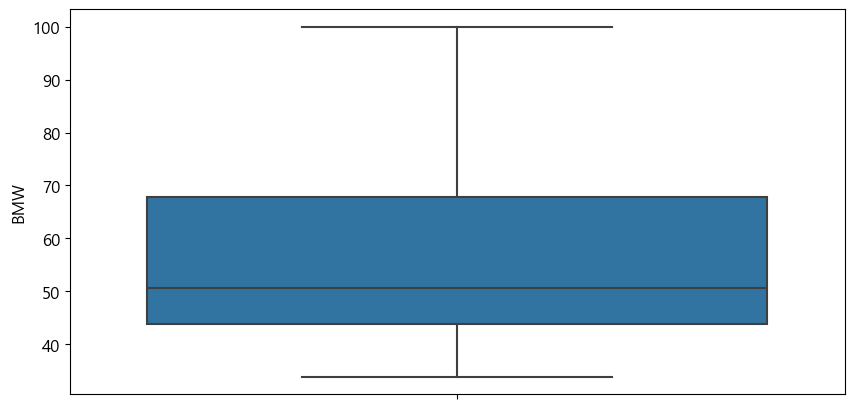

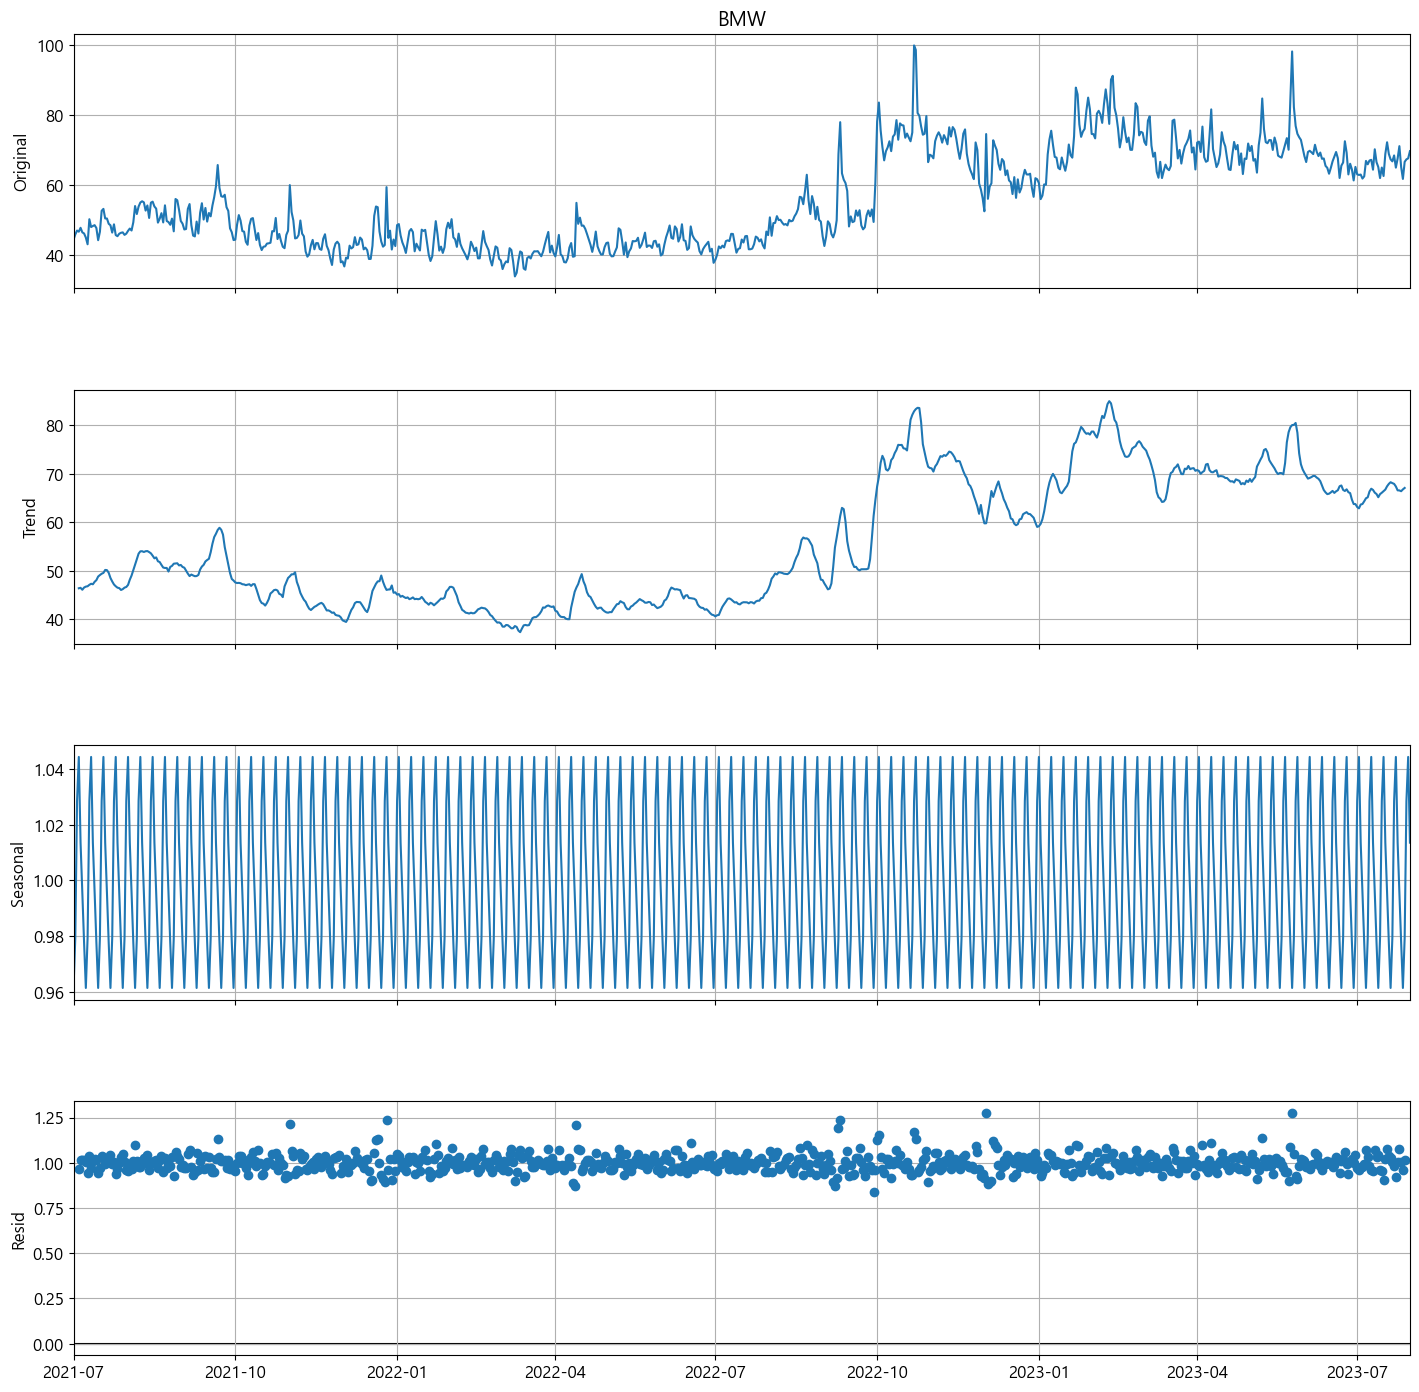

=========== 원본 데이터 ===========
+------------------------------------+-----------+
| ADF                                |           |
|------------------------------------+-----------|
| 검정통계량 (ADF Statistic)         | -0.924826 |
| p-value                            |  0.779687 |
| 최적 차수                          |        20 |
| 관측치 개수                        |       740 |
| 기각값 1%                          |  -3.43922 |
| 기각값 5%                          |  -2.86545 |
| 기각값 10%                         |  -2.56885 |
| 데이터 정상성 여부(0=Flase,1=True) |         0 |
+------------------------------------+-----------+


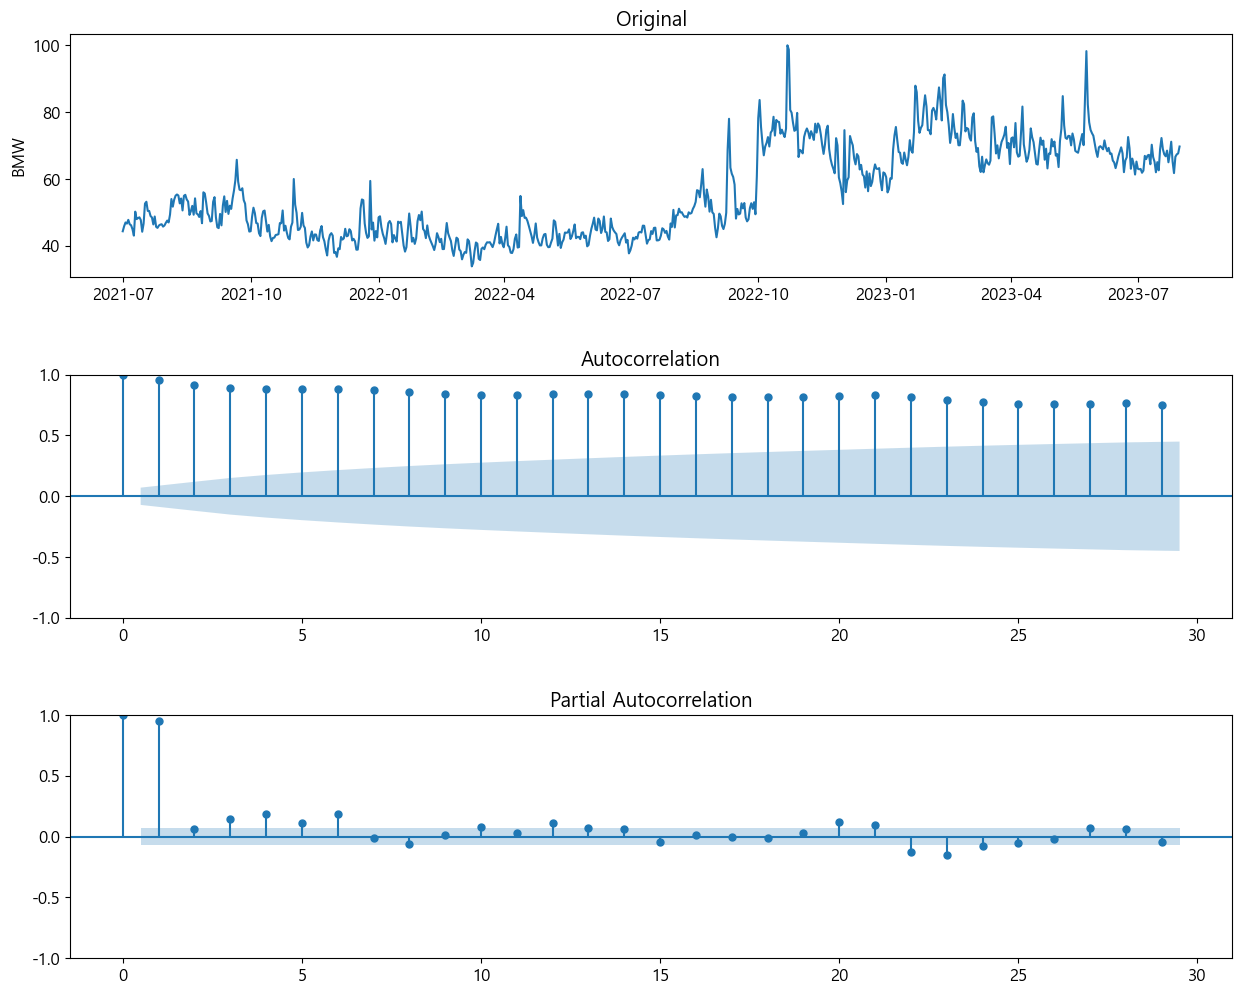

AUDI
결측치 수 :  0


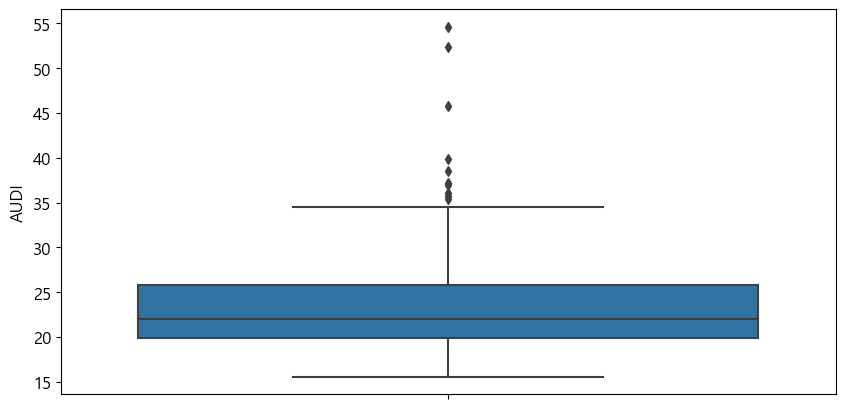

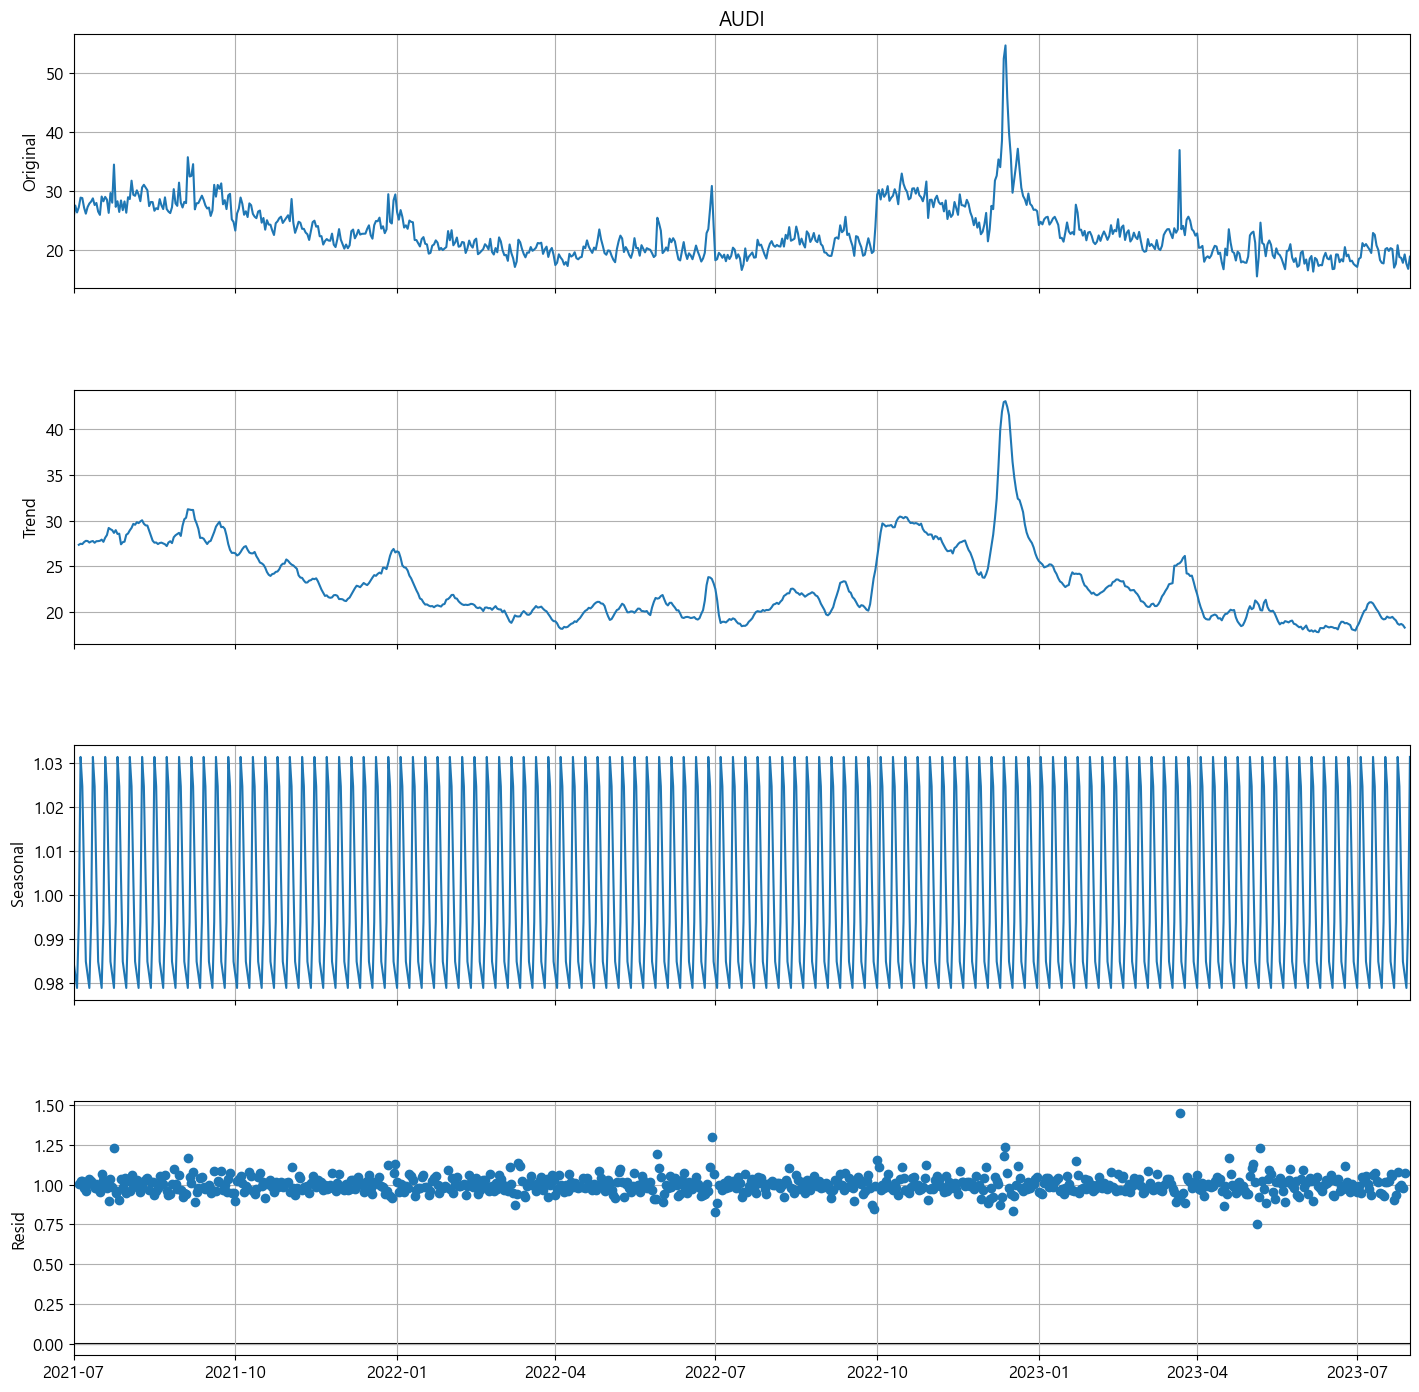

=========== 원본 데이터 ===========
+------------------------------------+------------+
| ADF                                |            |
|------------------------------------+------------|
| 검정통계량 (ADF Statistic)         |   -3.64569 |
| p-value                            | 0.00494533 |
| 최적 차수                          |          8 |
| 관측치 개수                        |        752 |
| 기각값 1%                          |   -3.43908 |
| 기각값 5%                          |   -2.86539 |
| 기각값 10%                         |   -2.56882 |
| 데이터 정상성 여부(0=Flase,1=True) |          1 |
+------------------------------------+------------+


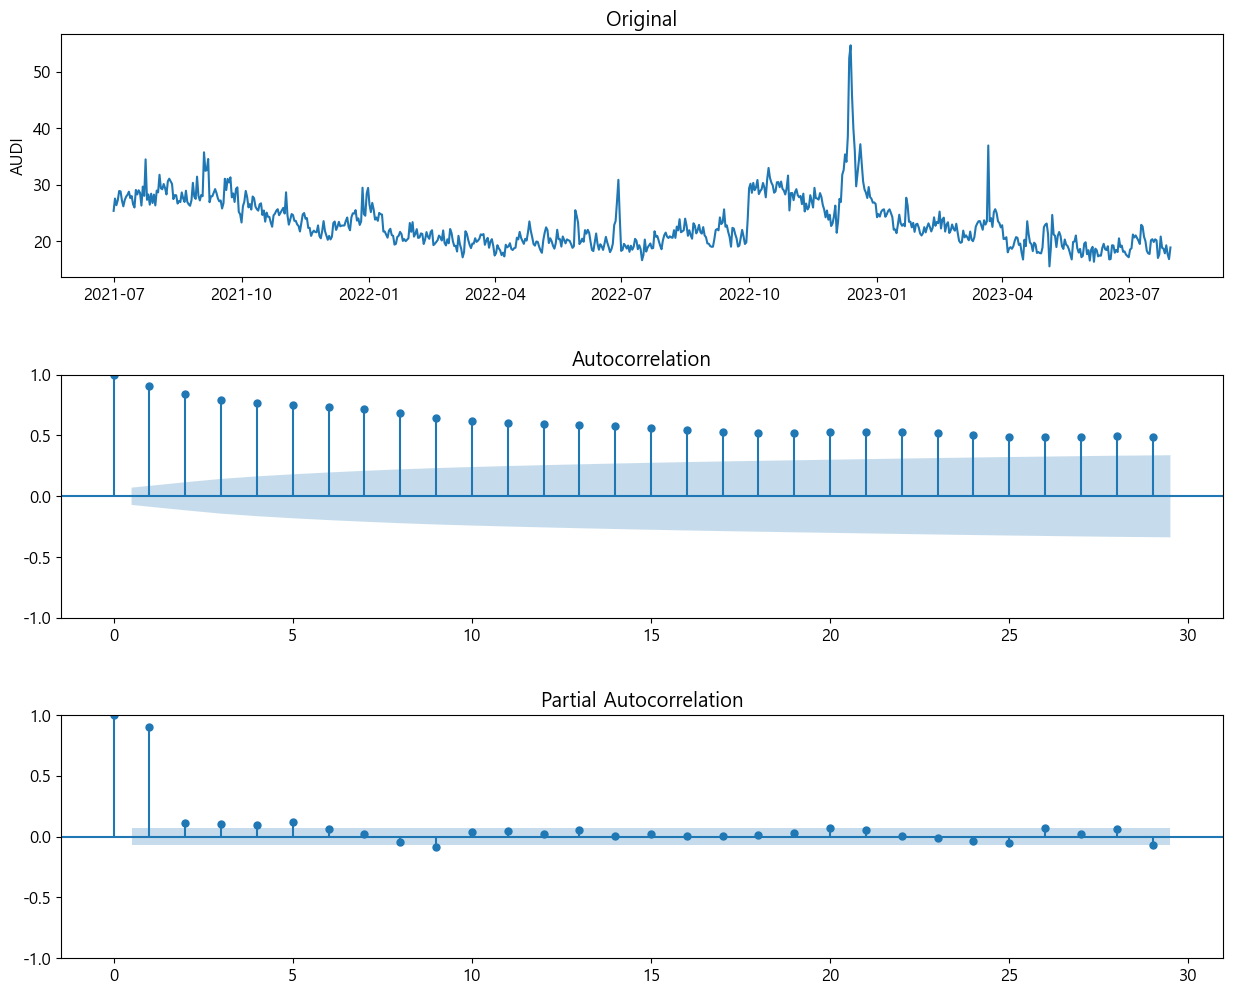

In [43]:
for c  in df2.columns :
    print("=========================================")
    print(c)
    print("=========================================")

    exp_timedata(df2, c, "m")



### ARIMA 분석 

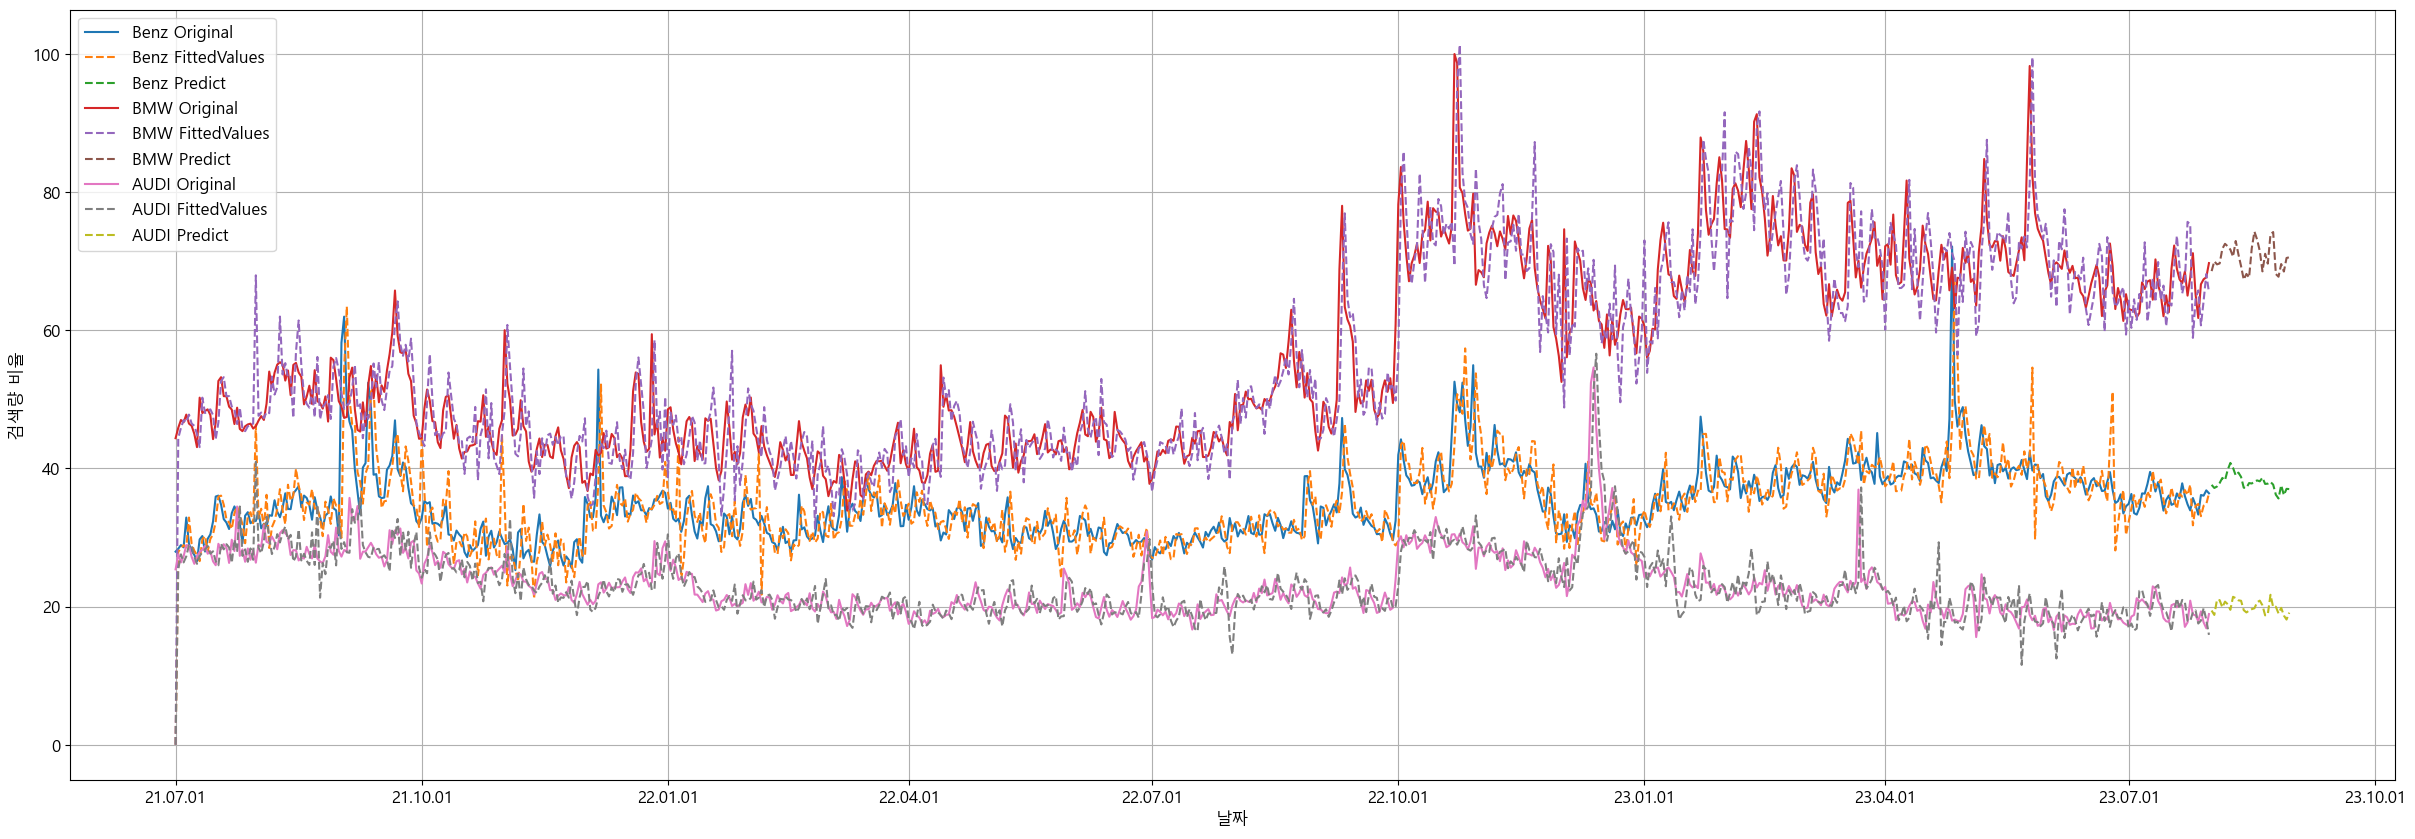

In [45]:
plt.figure(figsize=(30,10))

for c in df2.columns :
    model = ARIMA(df2[c],order=(1,1,0),seasonal_order=(1,1,0,30))
    fit = model.fit()
    fv = fit.fittedvalues
    fc = fit.forecast(30)
    sb.lineplot(data=df2, x=df2.index, y=c, label='%s Original' % c)
    sb.lineplot(x=fv.index, y=fv.values, label='%s FittedValues' % c, linestyle='--')
    sb.lineplot(x=fc.index, y=fc.values, label='%s Predict' % c, linestyle='--')

plt.xlabel('날짜')
plt.ylabel('검색량 비율')
plt.legend()

monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()